In [1]:
# Task 1
#
# Binary classification: clasify normal and abnormal rythms
# %%w
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# If you are loading the data from drive, load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
df_ptbd_normal = pd.read_csv("/content/drive/My Drive/Task_1/ptbdb_normal.csv", header = None)
df_ptbd_abnormal = pd.read_csv("/content/drive/My Drive/Task_1/ptbdb_abnormal.csv", header = None)
df_ptbd = pd.concat([df_ptbd_normal, df_ptbd_abnormal], axis = 0, ignore_index=True)
df_ptbd =df_ptbd.rename(columns={187: 'label'})
# classes are 0 (normal) and 1 (abnormal)
classes_names = {0 : "normal",
                 1 : "abnormal"}

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_ptbd_normal.shape[1] - 1
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])


The last time value is :  1488.0


In [41]:
X = df_ptbd.drop('label', axis=1)
y = df_ptbd['label']

# %%
X = X.values
y = y.values

# %%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

# %%
#training-validation split goes here
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=41)


In [42]:
# %%
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
X_val = torch.FloatTensor(X_val)

#labels of regular/irregular heartbeats are 0, 1 respectively
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
y_val = torch.LongTensor(y_val)


In [49]:
# %%
class Model(nn.Module):
    def __init__(self, in_features=187, h1=64, h2= 32, out_features=2):
      super().__init__() #this instantiates nn.Module
      self.fc1 = nn.Linear(in_features, h1)
      #self.dropout1 = nn.Dropout(p=0.4)
      self.fc2 = nn.Linear(h1, h2)
      #self.dropout2 = nn.Dropout(p=0.2)
      self.out = nn.Linear(h2, out_features)

    def forward_prop(self, a):
      a = F.relu(self.fc1(a))
      a = F.relu(self.fc2(a))
      a = self.out(a)
      a = F.sigmoid(a)
      return a

# %%
#initialises the model with a particular set of random weights and biases
torch.manual_seed(41)
#create an instance of out model
model = Model()

# %%
#set the cost function of the model
#in this case the loss function is CrossEntropyLoss
loss_function = nn.CrossEntropyLoss()
#chose the type of gradient descent/optimisation algorithm
#using an 'Adam' optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.0035)


In [50]:
#train the model
#1 Epoch: one run through all training data in the network
epochs = 240
#losses array keeps track of accuracy as we improve the network
losses = []
for i in range(epochs):
    a = model.forward_prop(X_train)
    #measures the loss for the output activation and the label
    a = a.squeeze()
    loss = loss_function(a, y_train)
    losses.append(loss.detach().numpy())
    if i%10==0:
      print(f"Epoch: {i}, loss: {loss}")

    #back_prop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0, loss: 0.6930049061775208
Epoch: 10, loss: 0.5848344564437866
Epoch: 20, loss: 0.579129695892334
Epoch: 30, loss: 0.5567658543586731
Epoch: 40, loss: 0.5464826226234436
Epoch: 50, loss: 0.5260918736457825
Epoch: 60, loss: 0.5039026737213135
Epoch: 70, loss: 0.4885127544403076
Epoch: 80, loss: 0.47719377279281616
Epoch: 90, loss: 0.46523070335388184
Epoch: 100, loss: 0.4548846483230591
Epoch: 110, loss: 0.4457569420337677
Epoch: 120, loss: 0.4380505084991455
Epoch: 130, loss: 0.43087446689605713
Epoch: 140, loss: 0.42352163791656494
Epoch: 150, loss: 0.4173233211040497
Epoch: 160, loss: 0.4120109975337982
Epoch: 170, loss: 0.40759873390197754
Epoch: 180, loss: 0.40325111150741577
Epoch: 190, loss: 0.3998577892780304
Epoch: 200, loss: 0.39569979906082153
Epoch: 210, loss: 0.3923734724521637
Epoch: 220, loss: 0.38966721296310425
Epoch: 230, loss: 0.38779231905937195


tensor(0.4133)

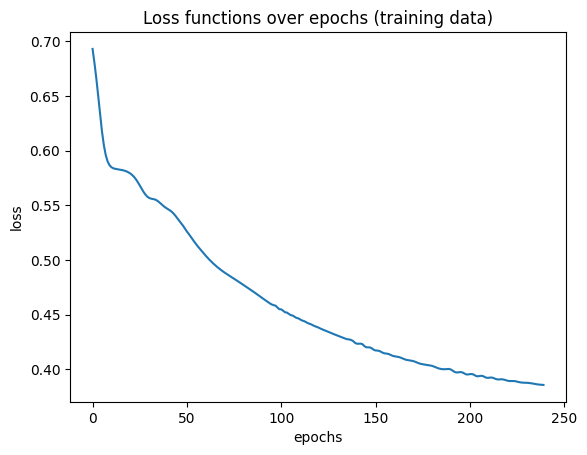

In [51]:
# %%
def model_accuracy_no_grad(x_data, y_data):
    correct = 0
    with torch.no_grad():
      for i, data in enumerate(x_data): #iterates through each image
        y_eval = model.forward_prop(data)
        if y_eval.argmax().item() == y_data[i]:
          correct +=1
    return (correct/len(x_data))*100

# %%
def model_accuracy(x_data, y_data):
    correct = 0
    for i, data in enumerate(x_data): #iterates through each image
      y_eval = model.forward_prop(data)
      if y_eval.argmax().item() == y_data[i]:
        correct +=1
    return (correct/len(x_data))*100


# %%
model_accuracy(X_train, y_train)

# %%
plt.plot(range(epochs), losses)
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title("Loss functions over epochs (training data)")

# %%
with torch.no_grad(): #turns off backprop
    y_eval = model.forward_prop(X_test)
    loss = loss_function(y_eval.squeeze(), y_test)
loss

In [52]:
print(model_accuracy_no_grad(X_val, y_val))

# %%
print(model_accuracy_no_grad(X_test,y_test))


89.62696335078533
89.85341273476867
